# Assignment 2

In [ ]:
# =================================================================================================
# Authors: Andrei Landayan Angeles (), Chathu Siriwardena (), Mark Sturtz (218306846)
# Description: Code document for group assessment task 2.
# =================================================================================================
# Version     |    Date      |    Author        |  Updates
# 0.1         |  23-Aug-2024 |    Andrei        |  Initial Version - Creating Git Repo
# 0.2         |  25-Aug-2024 |    Mark          |  Minor changes to log, add library imports & load data in spark df


#### Library Imports

In [2]:
import pandas as pd
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_replace, col
import matplotlib.pyplot as plt

In [5]:
# Initialize Spark session
spark = SparkSession.builder.appName("SIT742Task2").getOrCreate()

#### Load Data

In [6]:
# define external path with getcwd()
external_path = os.getcwd()

# define path do data
data_path = external_path+'/data/transactionrecord'

# create spark df from pandas df
df = spark.createDataFrame(pd.read_table(data_path, delimiter=','))

# display the first 5 rows
display(df.head(n=5))

[Row(TransactionNo='581482', Date='12/9/2019', ProductNo='22485', ProductName='Set Of 2 Wooden Market Crates', Product_category='0ca', Price=21.47, Quantity=12, CustomerNo=17490, Country='United Kingdom'),
 Row(TransactionNo='581475', Date='12/9/2019', ProductNo='22596', ProductName='Christmas Star Wish List Chalkboard', Product_category='0ca', Price=10.65, Quantity=36, CustomerNo=13069, Country='United Kingdom'),
 Row(TransactionNo='581475', Date='12/9/2019', ProductNo='23235', ProductName='Storage Tin Vintage Leaf', Product_category='0ca', Price=11.53, Quantity=12, CustomerNo=13069, Country='United Kingdom'),
 Row(TransactionNo='581475', Date='12/9/2019', ProductNo='23272', ProductName='Tree T-Light Holder Willie Winkie', Product_category='0ca', Price=10.65, Quantity=12, CustomerNo=13069, Country='United Kingdom'),
 Row(TransactionNo='581475', Date='12/9/2019', ProductNo='23239', ProductName='Set Of 4 Knick Knack Tins Poppies', Product_category='0ca', Price=11.94, Quantity=6, Custome

## Part 1

##### Answer 1.1

In [31]:
#1.1.1
# Looks and replaces 'NA' in CustomerNo column with '-1'
df = df.withColumn("CustomerNo", regexp_replace("CustomerNo", "NA", "-1"))

#1.1.2
# Processes the productName column to only have alphabet characters
df = df.withColumn("productName_process", regexp_replace(col("ProductName"), "[^A-Za-z]", ""))

# Displays the first five rows of the transactionrecord
df.show(5)


+-------------+---------+---------+--------------------+----------------+-----+--------+----------+--------------+--------------------+-------+
|TransactionNo|     Date|ProductNo|         ProductName|Product_category|Price|Quantity|CustomerNo|       Country| productName_process|Revenue|
+-------------+---------+---------+--------------------+----------------+-----+--------+----------+--------------+--------------------+-------+
|       581482|12/9/2019|    22485|Set Of 2 Wooden M...|             0ca|21.47|      12|     17490|United Kingdom|SetOfWoodenMarket...| 257.64|
|       581475|12/9/2019|    22596|Christmas Star Wi...|             0ca|10.65|      36|     13069|United Kingdom|ChristmasStarWish...|  383.4|
|       581475|12/9/2019|    23235|Storage Tin Vinta...|             0ca|11.53|      12|     13069|United Kingdom|StorageTinVintage...| 138.36|
|       581475|12/9/2019|    23272|Tree T-Light Hold...|             0ca|10.65|      12|     13069|United Kingdom|TreeTLightHolderW...| 

##### Answer 1.2

+-------------+---------+---------+--------------------+----------------+-----+--------+----------+--------------+--------------------+-------+
|TransactionNo|     Date|ProductNo|         ProductName|Product_category|Price|Quantity|CustomerNo|       Country| productName_process|Revenue|
+-------------+---------+---------+--------------------+----------------+-----+--------+----------+--------------+--------------------+-------+
|       581482|12/9/2019|    22485|Set Of 2 Wooden M...|             0ca|21.47|      12|     17490|United Kingdom|SetOfWoodenMarket...| 257.64|
|       581475|12/9/2019|    22596|Christmas Star Wi...|             0ca|10.65|      36|     13069|United Kingdom|ChristmasStarWish...|  383.4|
|       581475|12/9/2019|    23235|Storage Tin Vinta...|             0ca|11.53|      12|     13069|United Kingdom|StorageTinVintage...| 138.36|
|       581475|12/9/2019|    23272|Tree T-Light Hold...|             0ca|10.65|      12|     13069|United Kingdom|TreeTLightHolderW...| 

<ipython-input-30-a54c001d25c9>:9: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_pandas['transaction_date'] = pd.to_datetime(df_pandas['Date'], infer_datetime_format=True)


  TransactionNo       Date ProductNo                          ProductName  \
0        581482  12/9/2019     22485        Set Of 2 Wooden Market Crates   
1        581475  12/9/2019     22596  Christmas Star Wish List Chalkboard   
2        581475  12/9/2019     23235             Storage Tin Vintage Leaf   
3        581475  12/9/2019     23272    Tree T-Light Holder Willie Winkie   
4        581475  12/9/2019     23239    Set Of 4 Knick Knack Tins Poppies   

  Product_category  Price  Quantity CustomerNo         Country  \
0              0ca  21.47        12      17490  United Kingdom   
1              0ca  10.65        36      13069  United Kingdom   
2              0ca  11.53        12      13069  United Kingdom   
3              0ca  10.65        12      13069  United Kingdom   
4              0ca  11.94         6      13069  United Kingdom   

               productName_process     Revenue transaction_date  
0          SetOfWoodenMarketCrates  257.640015       2019-12-09  
1  Chris

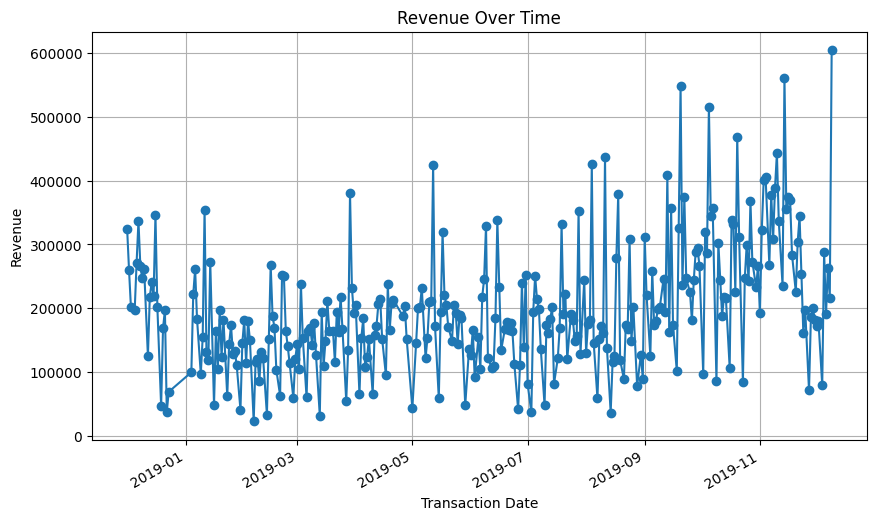

In [30]:
#1.2.1
# Calculates the revenue and displays the first 5 rows.
df = df.withColumn("Revenue", (col("Price") * col("Quantity")).cast("float"))
df.show(5)

#1.2.2
# Converts to pandas, and creates a transaction_date, and shows first 5 rows.
df_pandas = df.toPandas()
df_pandas['transaction_date'] = pd.to_datetime(df_pandas['Date'], infer_datetime_format=True)
print(df_pandas.head(5))

#1.2.3
# Plots the revenue over time
df_grouped = df_pandas.groupby('transaction_date')['Revenue'].sum()
df_grouped.plot(title='Revenue Over Time', xlabel='Transaction Date', ylabel='Revenue', figsize=(10, 6), marker='o')
plt.grid(True)
plt.show()


##### Answer 1.3

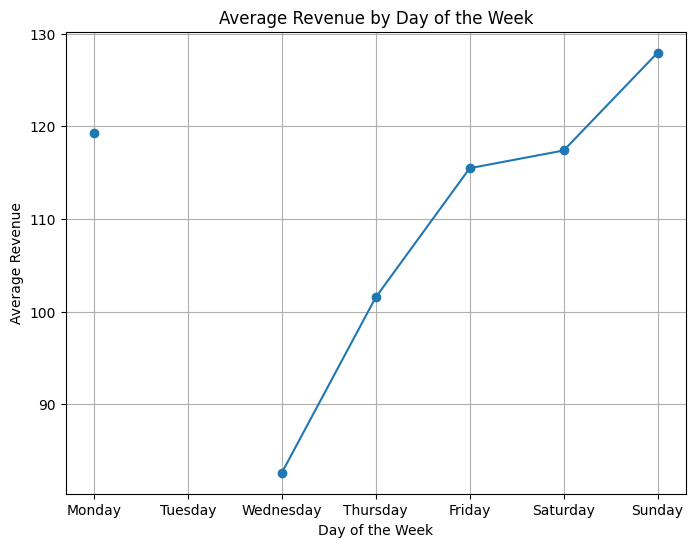

The workday with the highest average revenue is: Sunday


In [29]:
# 1.3.1
#Extract the day of the week from transaction_date
df_pandas['day_of_week'] = df_pandas['transaction_date'].dt.day_name()

# Average revenue by day of the week
average_revenue_by_day = df_pandas.groupby('day_of_week')['Revenue'].mean()

# Plot of average revenue by day of the week
average_revenue_by_day = average_revenue_by_day.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
average_revenue_by_day.plot(title='Average Revenue by Day of the Week', xlabel='Day of the Week', ylabel='Average Revenue', figsize=(8, 6), marker='o')
plt.grid(True)
plt.show()

# Workday with the highest average revenue
highest_revenue_day = average_revenue_by_day.idxmax()
print(f"The workday with the highest average revenue is: {highest_revenue_day}")


In [28]:
# 1.3.2 Filter the DataFrame for the top workday
df_top_workday = df_pandas[df_pandas['day_of_week'] == highest_revenue_day]

# The product with the highest revenue on that workday
top_product_by_revenue = df_top_workday.groupby('productName_process')['Revenue'].sum().idxmax()
print(f"The product with the highest revenue on {highest_revenue_day} is: {top_product_by_revenue}")

# The product with the highest sales volume on that workday
top_product_by_volume = df_top_workday.groupby('productName_process')['Quantity'].sum().idxmax()
print(f"The product with the highest sales volume on {highest_revenue_day} is: {top_product_by_volume}")


The product with the highest revenue on Sunday is: WorldWarGlidersAsstdDesigns
The product with the highest sales volume on Sunday is: WorldWarGlidersAsstdDesigns


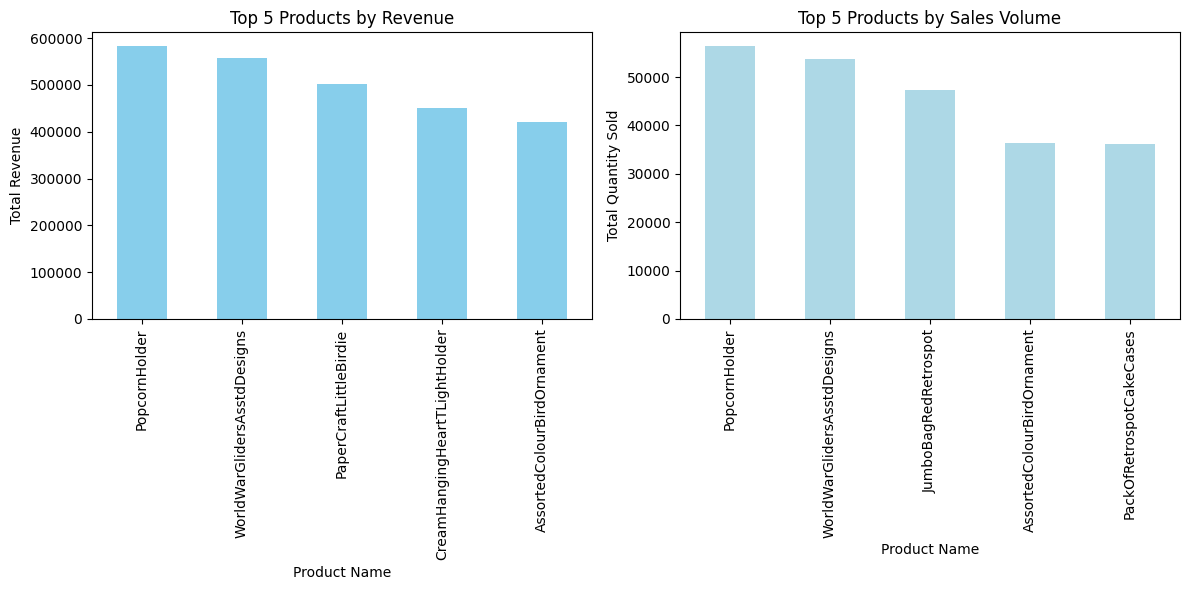

In [27]:
# 1.3.3 Find the top 5 products by revenue in general

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Top 5 products by revenue in general
top_5_products_by_revenue = df_pandas.groupby('productName_process')['Revenue'].sum().nlargest(5)

# Plot the top 5 products by revenue
top_5_products_by_revenue.plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Top 5 Products by Revenue')
axes[0].set_xlabel('Product Name')
axes[0].set_ylabel('Total Revenue')

# Top 5 products by sales volume in general
top_5_products_by_volume = df_pandas.groupby('productName_process')['Quantity'].sum().nlargest(5)

# Plot the top 5 products by sales volume
top_5_products_by_volume.plot(kind='bar', ax=axes[1], color='lightblue')
axes[1].set_title('Top 5 Products by Sales Volume')
axes[1].set_xlabel('Product Name')
axes[1].set_ylabel('Total Quantity Sold')

plt.tight_layout()

# Display the plots
plt.show()



## Part 2

##### Answer 2.1